In [2]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.datasets import load_wine
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report,auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import class_prediction_error
from yellowbrick.features import radviz
from yellowbrick.features import ParallelCoordinates
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import roc_auc
from yellowbrick.model_selection import ValidationCurve

In [4]:




data = load_wine()
X = data.data      # Feature matrix
y = data.target    # Target variable

feature_names = data.feature_names

X_fr=pd.DataFrame(X,columns=data.feature_names)
X_fr.rename(columns={'od280/od315_of_diluted_wines': 'od280-315'}, inplace=True)
y_fr=pd.DataFrame(y)
print(type(X_fr))
print(X_fr.shape)
print(X_fr.tail())

<class 'pandas.core.frame.DataFrame'>
(178, 13)
     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
173        0.61                  0.52             1.06              7.7  0.64   
174        0.75                  0.43             1.41              7.3  0.70   
175        0.69                  0.43             1.35             10.2  0.59   
176        0.68                  0.53             1.46              9.3  0.60   
177        0.76                  0.56             1.35              9.2 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_fr, y_fr,test_size=0.33, random_state=42, stratify=y)

#X_testorig=X_test.copy()

# This is needed for package that needs a Series as input.
y_trainorig=y_train
# THIS IS NEEDED FOR THE FIT FUNCTION OF THE ESTIMATORS. THE SERIES NEEDS TO BE CONVERTED TO 
#A 1-D ARRAY.
print(type(X_train))
y_train= y_train.to_numpy()
y_train=y_train.ravel()
print(type(y_train))
print(y_train.shape)
y_test= y_test.to_numpy()
y_test=y_test.ravel()

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(119,)


In [6]:

from sklearn.preprocessing import StandardScaler


ss = StandardScaler() # Standardization

X_sctrain = ss.fit_transform(X_train)
sd=pd.DataFrame(X_sctrain)

X_sctest = ss.fit_transform(X_test)




In [19]:
model_rf = RandomForestClassifier(n_estimators=500, criterion='gini',random_state=10,max_depth=10)
model_rf.fit(X_sctrain, y_train)
predicted_rf=model_rf.predict(X_sctest)
cm_rf = confusion_matrix(y_test, predicted_rf)
accuracy_rf = accuracy_score(y_test, predicted_rf)
print("confusion matrix")
print(cm_rf)
print("\n")
print("Accuracy of Random Forest:",accuracy_rf,'\n')
print(classification_report(y_test,predicted_rf))


confusion matrix
[[18  2  0]
 [ 0 23  0]
 [ 0  0 16]]


Accuracy of Random Forest: 0.9661016949152542 

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.92      1.00      0.96        23
           2       1.00      1.00      1.00        16

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59



In [13]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=8)
sizes = np.linspace(0.3, 1.0, 10)


In [14]:
visualizer = LearningCurve(
    model_rf, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

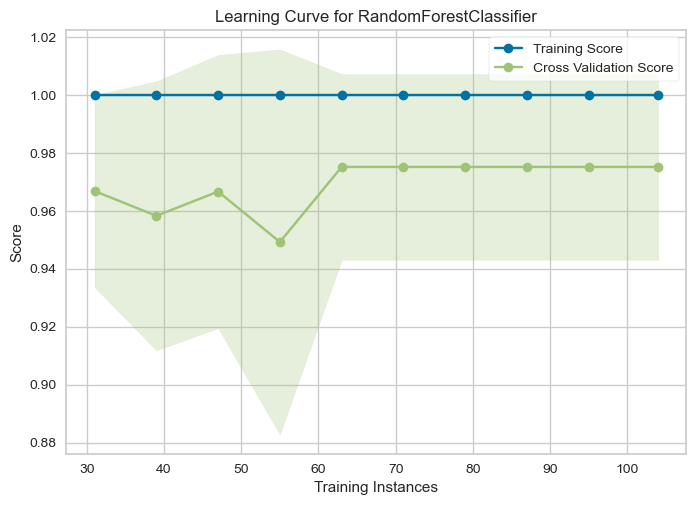

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [15]:
visualizer.fit(X_sctrain, y_train)        # Fit the data to the visualizer
visualizer.show()  

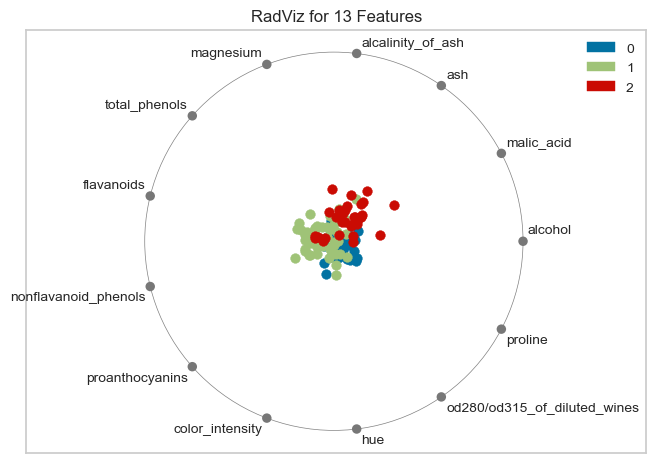

RadialVisualizer(ax=<Axes: title={'center': 'RadViz for 13 Features'}>,
                 classes=[0, 1, 2],
                 features=['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash',
                           'magnesium', 'total_phenols', 'flavanoids',
                           'nonflavanoid_phenols', 'proanthocyanins',
                           'color_intensity', 'hue',
                           'od280/od315_of_diluted_wines', 'proline'])

In [16]:
classes = [0,1,2]
radviz(X_sctrain, y_train, classes=classes, features=feature_names)

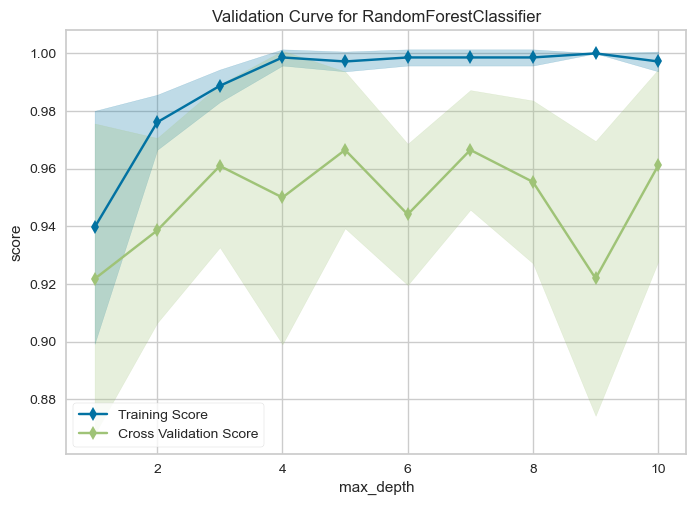

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [17]:
model = RandomForestClassifier(n_estimators=10)
param_range = np.arange(1, 11) 
# Create the validation curve visualizer
viz = ValidationCurve(
    model, param_name="max_depth", param_range=param_range,
    cv=StratifiedKFold(5), scoring="accuracy", n_jobs=-1
)
# Fit and show the visualizer
y_fr=y_fr.to_numpy()
y_fr=y_fr.ravel()
viz.fit(X_fr, y_fr)
viz.show()

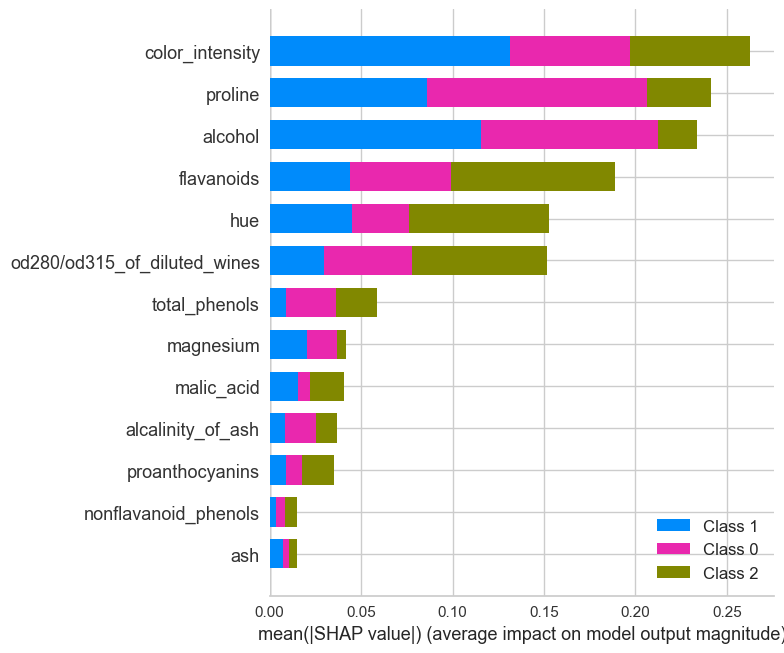

In [12]:
# Calculate Shap values
shap_values = shap.TreeExplainer(model_rf).shap_values(X_sctrain)
shap.summary_plot(shap_values, X_sctrain,feature_names=feature_names, plot_type="bar")
